In [74]:
import sys
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import keras.layers as kl
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Input, Concatenate
from tensorflow.keras.models import Model
import csv


path = 'C:/Users/ian03/Desktop/MLproject/Latest/AudioNNRep/functions'
sys.path.append('C:/Users/ian03/Desktop/MLproject/Latest/AudioNNRep/functions')

import functions as f

inst_path = "C:/Users/ian03/Desktop/MLproject/AudioNNRepository/audio/"

def torch_normalize(spec):
    return (spec - torch.min(spec)) / (torch.max(spec) - torch.min(spec))



In [75]:
#Initialize the list of instruments
filenames = f.read_files_in_dir(inst_path)
#pianos = [filename for filename in filenames if "piano" in filename] #empty
bass = [filename for filename in filenames if "bass" in filename]
guitar = [filename for filename in filenames if "guitar" in filename]
#drum = [filename for filename in filenames if "drum" in filename] #empty
flutes = [filename for filename in filenames if "flute" in filename]
keyboards = [filename for filename in filenames if "keyboard" in filename] 


instrument_list = [bass, guitar, flutes, keyboards]

In [76]:
data, labels, original_labels = f.nu_gen_constant_mel_spectro(100, [bass, keyboards], path = inst_path)


print(labels.shape)

(100, 2, 128, 285)


In [77]:
class AudioDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


# Split the data into training and testing sets
#data = data[..., np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(y_train.shape)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)
print(X_train.shape)

# Create the datasets and dataloaders
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
#print(train_dataset[0][0].shape)

# Get a batch of data
inputs, targets = next(iter(train_loader))

# Print the shape of the inputs
print(inputs.shape)

(80, 2, 128, 285)
(80, 1, 128, 285)
torch.Size([2, 1, 128, 285])


In [79]:
# Initialize the model, loss function, and optimizer
#import torch_directml

#device = torch_directml.device()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_channels = X_train.shape[1]  # Get the number of input channels from the data
#model = UNetDConv(in_channels=1,out_channels=4).to(device, dtype=torch.float32)
print(device)

cpu


In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, in_channels):
        super(Attention, self).__init__()
        self.in_channels = in_channels
        self.attention = nn.MultiheadAttention(embed_dim=in_channels, num_heads=1, batch_first=True)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)
        attn_output, _ = self.attention(x, x, x)
        attn_output = attn_output.permute(0, 2, 1).view(batch_size, self.in_channels, height, width)
        return attn_output
    
class DilatedConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(DilatedConv, self).__init__()
        padding = (kernel_size - 1) * dilation // 2  # Corrected padding calculation
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, dilation=dilation, padding=padding)  # Use calculated padding

    def forward(self, x):
        return self.conv(x)

class DConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):  
        super(DConvBlock, self).__init__()
        dil = 2
        padding = (kernel_size - 1) * dil // 2  # Corrected padding calculation

        self.dilated_conv = nn.Sequential(
            DilatedConv(in_channels, in_channels, kernel_size, dilation=dil),  # Use DilatedConv with correct padding
            nn.ReLU()
        )
        self.pointwise_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),  # No padding needed for kernel size 1
            nn.ReLU()
        )

    def forward(self, x):
        x = F.relu(self.dilated_conv(x))
        x = F.relu(self.pointwise_conv(x))

        return x
    
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2 * hidden_size, 2 * hidden_size)  

    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size, device = device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size, device = device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        out = self.linear(out)
        



        return out
    
class UNetDConv(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_size, num_layers):
        super(UNetDConv, self).__init__()
        self.bilstm = BiLSTM(8, hidden_size, num_layers)

        self.encoder = nn.ModuleList([
            DConvBlock(in_channels, hidden_size),
            nn.MaxPool2d(2, 2),  # Remove padding here
            DConvBlock(hidden_size, hidden_size * 2),
            nn.MaxPool2d(2, 2),  # And here
        ])

        self.decoder = nn.ModuleList([
            nn.ConvTranspose2d(hidden_size * 2, hidden_size, 2, stride=2, padding=1, output_padding=1),  # Add padding and output_padding here
            DConvBlock(hidden_size, hidden_size),
            nn.ConvTranspose2d(hidden_size, hidden_size, 2, stride=2, padding=1, output_padding=1),  # And here
            DConvBlock(hidden_size, out_channels),
        ])

        self.final_layer = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.ReLU()
        )
        # Add a padding layer to adjust the output shape
        self.padding = nn.ConstantPad2d((0, 4, 0, 3), 0)  # Padding on the right and bottom

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.float()
        batch_size, channels, height, width = x.shape

        # Encoder
        for layer in self.encoder:
            x = layer(x)

        # Calculate new height, width, and channels
        _, channels, new_height, new_width = x.shape

        x = x.reshape(batch_size, channels, new_height * new_width).transpose(1, 2)

        # BiLSTM
        x = self.bilstm(x)

        # Reshape it back to the reduced dimensions
        x = x.reshape(batch_size, self.bilstm.hidden_size*2, new_height, new_width)

        # Decoder
        for layer in self.decoder:
            x = layer(x)

        # Final Convolution
        out = self.final_layer(x)

        # Apply padding
        out = self.padding(out)
        return torch.abs(out)
            
x = torch.randn(2, 1, 128, 125).to(device, torch.float32) #example input 
model = UNetDConv(in_channels=1, out_channels=4, hidden_size=4, num_layers=1).to(device, dtype = torch.float32)  # Example with 2 output channels
output = model(x).to(device, dtype = torch.float32)
print(output.shape)  

torch.Size([2, 4, 128, 125])


In [13]:

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

# tager alt for lang tid med hidden_size = 1000...

model = UNetDConv(in_channels=1, out_channels=2, hidden_size=50, num_layers=2).to(device, dtype = torch.float32)  # Example with 2 output channels
#model.load_state_dict(torch.load('your_model_weights13.pth'))
#model.load_state_dict(torch.load('your_model_weights19.pth'))

class WeightedMSELoss(nn.Module):
    def __init__(self, weight_zero=0.1):
        super(WeightedMSELoss, self).__init__()
        self.weight_zero = weight_zero

    def forward(self, input, target):
        # Create a mask with 1 for non-zero values and `weight_zero` for zero values
        mask = torch.where(target != 0, 1, self.weight_zero)
        mask = mask.to(input.device)  # Ensure mask is on the right device
        # Calculate MSE loss
        loss = F.mse_loss(input, target, reduction='none')
        # Apply mask
        loss = loss * mask
        # Return mean loss
        return loss.mean()


class SDR(nn.Module):
    def __init__(self, return_individual_results=False):
        super(SDR, self).__init__()
        self.return_individual_results = return_individual_results
        self.batch = 0

    def forward(self, y_pred, y_true):
        # Ensure that we avoid log of zero by adding a small epsilon
        epsilon = 1e-7
        penalty2 = 0
        # Compute the numerator and denominator

        """    
        else: 
            if y_true.shape[0] == 1:
                num = torch.sum(torch.square(torch.squeeze(y_true)), dim = (1, 2))
                den = torch.sum(torch.square(torch.squeeze(y_true - y_pred)), dim = (1, 2))
            else:
                num = torch.sum(torch.square(torch.squeeze(y_true)), dim = (2, 3))
                den = torch.sum(torch.square(torch.squeeze(y_true - y_pred)), dim = (2, 3))
        """  

        #num = torch.sum(torch.square(y_true), dim = (2, 3))
        #den = torch.sum(torch.square(y_true - y_pred), dim = (2, 3))  

        mse = torch.sum(torch.square(y_true - y_pred), dim = (2, 3))

        #scores = 10 * torch.log10((num + epsilon) / (den + epsilon))
        #min = torch.min(scores)
        penalty = 0

        #if min < 0:
        #    num_elements_less_than_zero = torch.sum(scores < 0).item()
        #    penalty = -min * num_elements_less_than_zero # penalize the negative values
        
        
        mask = torch.gt(y_true, 0)
        positive_values = torch.sum(mask).item()
        
        penalty2 = torch.sum(torch.square(y_true[mask] - y_pred[mask]))

        regulator = 0.1
        penalty = regulator * penalty

        penalty3 = 0
        """ penalty 3
        for i in range(y_true.shape[0]):
            for j in range(y_true.shape[1]):
                penalty3 += torch.abs(torch.mean(y_pred[i, j, :, :]) - torch.mean(y_true[i, j, :, :]))

        """
        #calculate the number of zero spectrograms in y_true and y_pred
        num_zero_true = 0
        num_zero_pred = 0
        for i in range(y_true.shape[0]):
            for j in range(y_true.shape[1]):
                mean_true = torch.mean(y_true[i, j, :]).item()
                mean_pred = torch.mean(y_pred[i, j, :]).item()
                if mean_true == 0:
                    num_zero_true += 1
             
                if mean_pred == 0:
                    num_zero_pred += 1

        
        

        # Compute the loss

        #neg_sdr = -torch.mean(scores) * 1000

        
        #loss = neg_sdr + penalty + penalty2 + penalty3

        #loss = torch.mean(den)+ penalty + penalty2 + penalty3 * 100 # virkede ret godt   
        mse_out = torch.mean(mse)
        loss = mse_out / 10 + penalty2# virkede ret godt
        self.batch += 1

        print(f"Batch: {self.batch}, Loss: {loss:.1f} Penalties: {mse_out.item():.1f} , {penalty2.item():.1f}, mean {torch.mean(y_pred).item():.1f} pos: {positive_values}, zeros: {num_zero_true}, {num_zero_pred} ---------", end = '\r')
        
        if self.return_individual_results:
            return loss, penalty#, neg_sdr
        else:
            return loss, penalty#, neg_sdr

num_epochs = 10
patience = 3

criterion = SDR()
optimizer = optim.Adam(model.parameters(), lr=0.02)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min') # Implement learning rate scheduler

# Train the model
best_loss = np.inf
wait = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
        #print(f"Shape of x : {X.shape},Shape of y {y.shape}")
        optimizer.zero_grad() 


        y_pred = model(torch_normalize(X))
        loss, penalty = criterion(y_pred, y)
        #loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0) # Accumulate loss
        #print(f"Loss: {loss.item()}")
    val_loss = 0.0
    model.eval()
    #Implement early stopping
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
            y_pred = model(X)
            #loss = criterion(y_pred, y)

            loss, penalty = criterion(y_pred, y)
            
            val_loss += 4*loss.item() * X.size(0)
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        wait = 0
    else:
        wait += 1
    if wait > patience:
        break

    epoch_loss = running_loss
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')


model.eval()
losses = []
weights = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
        y_pred = model(X)
        #loss = criterion(y_pred, y)

        loss, penalty = criterion(y_pred, y)
        losses.append(loss.item() * X.size(0))
        weights.append(X.size(0))

average_loss = sum(losses) / len(test_loader.dataset)
print(f'Average Loss: {average_loss:.4f}')
torch.save(model.state_dict(), 'your_model_weights21.pth')

: 

In [26]:
model = UNetDConv(in_channels=1, out_channels=2, hidden_size=50, num_layers=2).to(device, dtype = torch.float32)  # Example with 2 output channels
model.load_state_dict(torch.load('your_model_weights21.pth'))


<All keys matched successfully>

index: 74
(2, 128, 285)
y_data shape: torch.Size([1, 2, 128, 285])
output shape: torch.Size([1, 2, 128, 285])
72960
loss: 15.684064865112305alties: 0.0 , 15.7, 0.0 pos: 3564, zeros: 0, 0
mean: 0.02234833501279354
y shape (128, 285), max = 1.480046272277832
mean: 0.012194431386888027
y shape (128, 285), max = 3.2289395332336426
output shape: (1, 2, 128, 285)
out mean 0.06930141896009445
out shape (128, 285), max = 31.652950286865234
out mean 0.07179596275091171
out shape (128, 285), max = 34.35679626464844


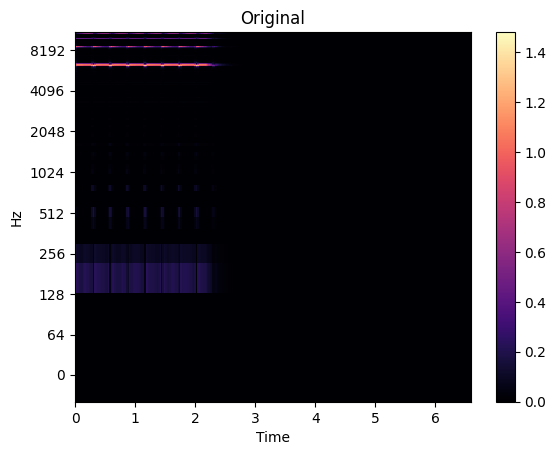

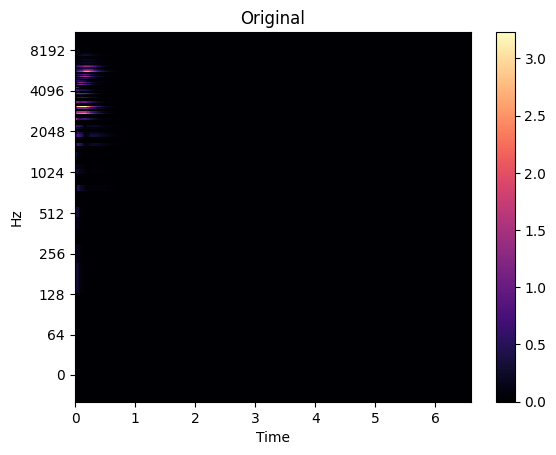

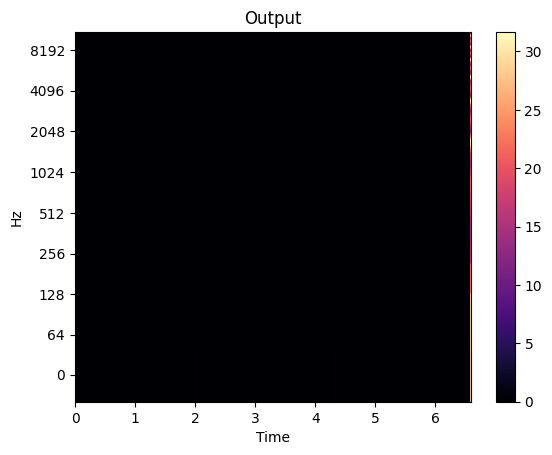

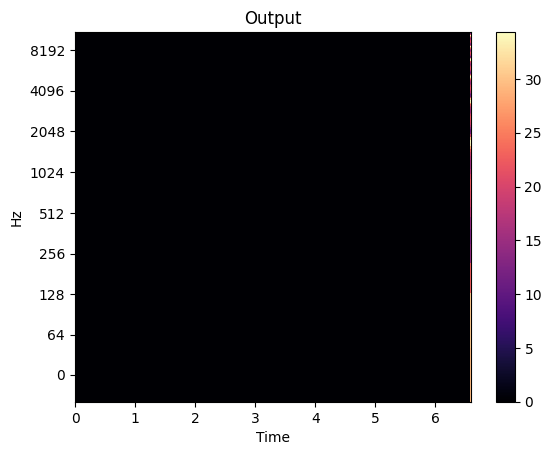

In [29]:

criterion = SDR(return_individual_results=True)


#Apply the model
loss = 1000


        #Pick a random sample from the data

    #make sure it includes the right index:

index = np.random.randint(0, len(X_train))
print(f"index: {index}")
input_data = X_train[index]
y_data1 = y_train[index]
input_data = np.expand_dims(input_data, axis=0)
y_data = np.expand_dims(y_data1, axis=0)

print(np.shape(y_data1))

input_data = torch.from_numpy(input_data).to(device, dtype=torch.float32)
y_data = torch.from_numpy(y_data).to(device, dtype=torch.float32)
with torch.no_grad():
    output_tensor = model(input_data)
    #evaluate the output
    print(f"y_data shape: {y_data.shape}")
    print(f"output shape: {output_tensor.shape}")
    
    loss, penalty = criterion(output_tensor, y_data)

    print(f"loss: {loss}")


for y in y_data1:
    #plot the original spectrograms
    print(f"mean: {np.mean(y)}")
    print(f"y shape {y.shape}, max = {np.max(y)}")
    plt.figure()
    
    librosa.display.specshow(y, sr=22050, x_axis='time', y_axis='log')

    plt.colorbar()
    plt.title("Original")
    
output_tensor = output_tensor.numpy()
print(f"output shape: {output_tensor.shape}")
for out in output_tensor:
    for spectro in out:
    #plot the output spectrograms
        print(f"out mean {np.mean(spectro)}")
        print(f"out shape {spectro.shape}, max = {np.max(spectro)}")
        plt.figure()

        librosa.display.specshow(spectro, sr=22050, x_axis='time', y_axis='log')
        plt.colorbar()
        plt.title("Output")



[array([-0.00250244, -0.0045166 , -0.0045166 , ...,  0.        ,
        0.        ,  0.        ], dtype=float32)]


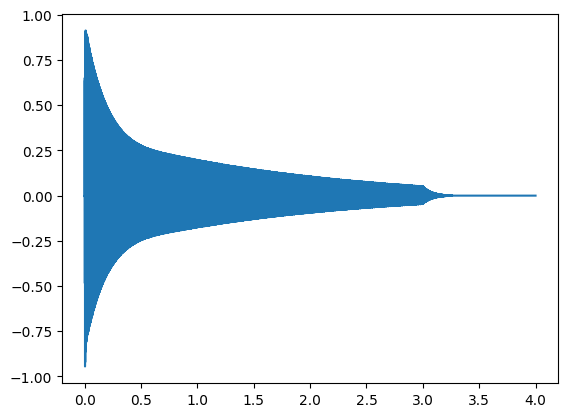

In [ ]:
#Generate a random waveform
import matplotlib.pyplot as plt
import soundfile as sf
#Pick a random sample of each instrument
filepaths, labels = f.pick_samples_and_classify(instrument_list)

#Extract .wav data into to a list
waveforms = f.add_waveform_to_list(filepaths, path = inst_path)

#Combine the waveforms
combined_waveform = f.combine_waveforms(waveforms)

print(waveforms)
#Save the combined waveform to a wav file using librosa
sf.write('combined_waveform.wav', combined_waveform, 16000)

frame_rate = 16000
time = np.linspace(0, len(combined_waveform)/frame_rate, num=len(combined_waveform))

plt.figure()
plt.plot(time, combined_waveform)


In [ ]:
filepaths

[array(['guitar_electronic_022-076-025.wav'], dtype='<U33')]

28.356812
written as guitar_electronic_022-076-025.wav.wav


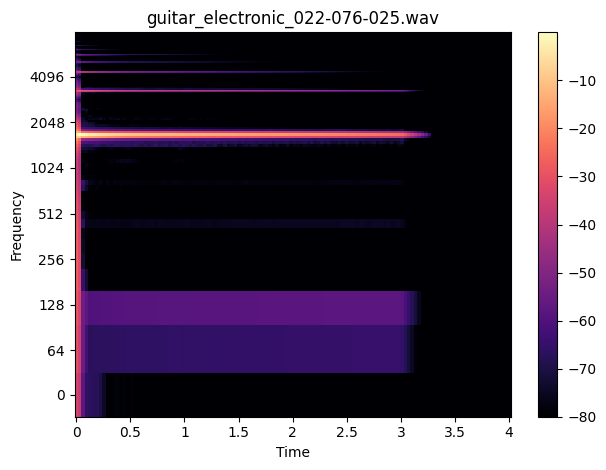

16000


In [ ]:
import wave
import matplotlib.pyplot as plt

def to_mel_spectrogram(spectrogram, sr, n_mels = 128):
    return librosa.feature.melspectrogram(y = None, sr=sr, S = spectrogram, n_mels=128)

def mel_spectro_to_wavefile(mel_spectro, sr, filename):
    audio = librosa.feature.inverse.mel_to_audio(mel_spectro, sr=sr)
    #write to wavefile

    sf.write(filename, audio, sr)
    print(f"written as {filename}")

for file in filepaths:
    st_file = "C:/Users/ian03/Desktop/MLproject/AudioNNRepository/audio/" + file[0]
    
    waveform, input_sr = librosa.load(st_file, sr=None)
    spectro = f.waveform_to_spectrogram(waveform)
    mel_spectro = to_mel_spectrogram(spectro, input_sr)
    print(np.max(mel_spectro))
    plt.figure()

    librosa.display.specshow(librosa.amplitude_to_db(mel_spectro, ref=np.max), sr=input_sr, x_axis='time', y_axis='log')

    mel_spectro_to_wavefile(mel_spectro, input_sr, file[0] + ".wav")
    
    plt.colorbar()
    plt.title(file[0])
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    print(input_sr)

    


In [ ]:
import os
output_folder = "output_audio"
os.makedirs(output_folder, exist_ok=True)   
for i, source in enumerate(output_tensor):
    output_filepath = os.path.join(output_folder, f"output_{i}.wav")
    f.spectrogram_to_audio(source, input_sr, output_filepath)

In [ ]:
#Plot the input spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(spectrogam, ref=np.max), sr=input_sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Input Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


NameError: name 'spectrogam' is not defined

<Figure size 1000x400 with 0 Axes>